In [20]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np
from networkx.algorithms import community, bipartite
from constants import stablecoins
from utils import create_graph #, plot_degree_distribution, edge_to_remove, girvan_newman

### Load Data

In [21]:
df = pd.read_csv("all_coins_data.csv")

In [22]:
#df = read_data("all_coins_data.csv")
nodes = list(set(df.coin))#Get unique list of coins
volatile_coins = [n for n in nodes if nodes not in stablecoins]
df["stablecoin"] = [1 if c in stablecoins else 0 for c in df["coin"]]
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversion_type,conversion_symbol,coin,daily_return_pct,intraday_return,daily_log_return,stablecoin
0,2020-08-22,0.1262,0.1183,0.1229,84207229.64,10373929.94,0.1253,direct,NaN,ADA,0.019528,0.019528,0.019340,0
1,2020-08-23,0.1259,0.1195,0.1253,64772529.12,7945897.18,0.1215,direct,NaN,ADA,-0.030327,-0.030327,-0.030797,0
2,2020-08-24,0.1270,0.1201,0.1215,77809944.45,9662533.63,0.1237,direct,NaN,ADA,0.018107,0.018107,0.017945,0
3,2020-08-25,0.1238,0.1063,0.1237,65939158.71,7699604.99,0.1126,direct,NaN,ADA,-0.089733,-0.089733,-0.094018,0
4,2020-08-26,0.1183,0.1107,0.1126,21686624.36,2483949.36,0.1144,direct,NaN,ADA,0.015986,0.015986,0.015859,0


#### Return Analysis

#### Risk Matrix

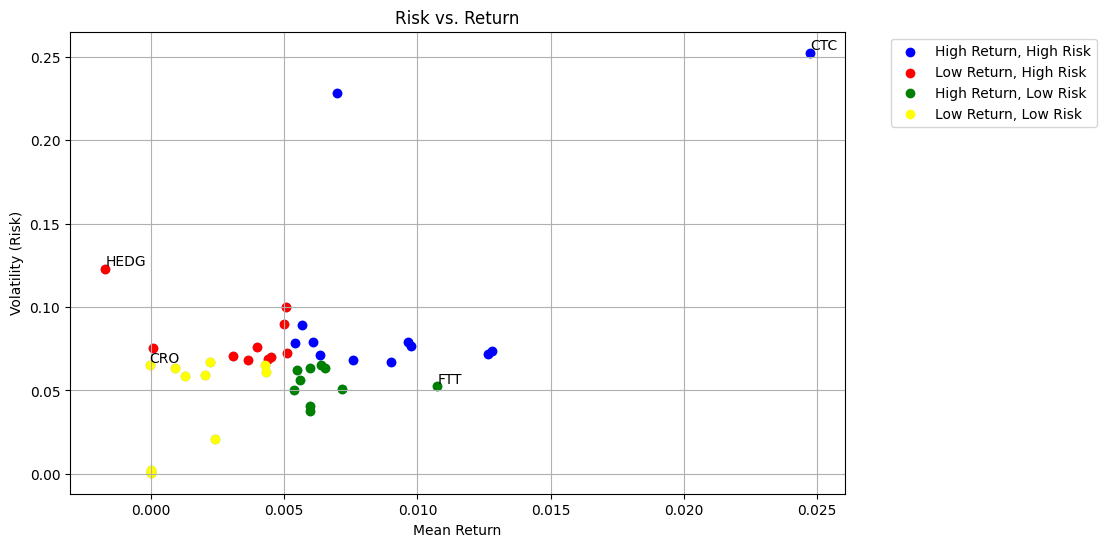

In [23]:
# Calculate volatility (standard deviation) for each stock
volatility_df = df.groupby('coin')['daily_log_return'].std().reset_index()
volatility_df.rename(columns={'daily_log_return': 'volatility'}, inplace=True)

# Calculate mean return for each stock
mean_return_df = df.groupby('coin')['daily_log_return'].mean().reset_index()
mean_return_df.rename(columns={'daily_log_return': 'mean_return'}, inplace=True)

# Merge the volatility and mean return DataFrames
risk_return_df = pd.merge(volatility_df, mean_return_df, on='coin')

# Define the quadrants based on mean return and volatility thresholds
high_return_high_risk = risk_return_df[(risk_return_df['mean_return'] > risk_return_df['mean_return'].median()) &
                                      (risk_return_df['volatility'] > risk_return_df['volatility'].median())]
low_return_high_risk = risk_return_df[(risk_return_df['mean_return'] <= risk_return_df['mean_return'].median()) &
                                     (risk_return_df['volatility'] > risk_return_df['volatility'].median())]
high_return_low_risk = risk_return_df[(risk_return_df['mean_return'] > risk_return_df['mean_return'].median()) &
                                      (risk_return_df['volatility'] <= risk_return_df['volatility'].median())]
low_return_low_risk = risk_return_df[(risk_return_df['mean_return'] <= risk_return_df['mean_return'].median()) &
                                     (risk_return_df['volatility'] <= risk_return_df['volatility'].median())]

# Identify the stock with the highest return at the lowest risk
highest_return_lowest_risk_stock = high_return_low_risk[high_return_low_risk['mean_return'] == high_return_low_risk['mean_return'].max()]

# Identify the stock with the highest return and highest risk
highest_return_highest_risk_stock = high_return_high_risk[high_return_high_risk['mean_return'] == high_return_high_risk['mean_return'].max()]

# Identify the stock with the lowest return and lowest risk
lowest_return_lowest_risk_stock = low_return_low_risk[low_return_low_risk['mean_return'] == low_return_low_risk['mean_return'].min()]

# Identify the stock with the lowest return and highest risk
lowest_return_highest_risk_stock = low_return_high_risk[low_return_high_risk['mean_return'] == low_return_high_risk['mean_return'].min()]

# Plot the scatter plot to analyze the relationship between risk and return
plt.figure(figsize=(10, 6))
plt.scatter(risk_return_df['mean_return'], risk_return_df['volatility'], alpha=0.5)
plt.xlabel('Mean Return')
plt.ylabel('Volatility (Risk)')
plt.title('Risk vs. Return')
plt.grid(True)

# Plot each quadrant with different markers
plt.scatter(high_return_high_risk['mean_return'], high_return_high_risk['volatility'], color='blue', marker='o', label='High Return, High Risk')
plt.scatter(low_return_high_risk['mean_return'], low_return_high_risk['volatility'], color='red', marker='o', label='Low Return, High Risk')
plt.scatter(high_return_low_risk['mean_return'], high_return_low_risk['volatility'], color='green', marker='o', label='High Return, Low Risk')
plt.scatter(low_return_low_risk['mean_return'], low_return_low_risk['volatility'], color='yellow', marker='o', label='Low Return, Low Risk')

# Label stocks identified in each quadrant
highest_return_lowest_risk_stock_label = risk_return_df[risk_return_df['coin'] == highest_return_lowest_risk_stock['coin'].values[0]]
highest_return_highest_risk_stock_label = risk_return_df[risk_return_df['coin'] == highest_return_highest_risk_stock['coin'].values[0]]
lowest_return_lowest_risk_stock_label = risk_return_df[risk_return_df['coin'] == lowest_return_lowest_risk_stock['coin'].values[0]]
lowest_return_highest_risk_stock_label = risk_return_df[risk_return_df['coin'] == lowest_return_highest_risk_stock['coin'].values[0]]

plt.text(highest_return_lowest_risk_stock_label['mean_return'].values[0], highest_return_lowest_risk_stock_label['volatility'].values[0], highest_return_lowest_risk_stock_label['coin'].values[0], ha='left', va='bottom', fontsize=10)
plt.text(highest_return_highest_risk_stock_label['mean_return'].values[0], highest_return_highest_risk_stock_label['volatility'].values[0], highest_return_highest_risk_stock_label['coin'].values[0], ha='left', va='bottom', fontsize=10)
plt.text(lowest_return_lowest_risk_stock_label['mean_return'].values[0], lowest_return_lowest_risk_stock_label['volatility'].values[0], lowest_return_lowest_risk_stock_label['coin'].values[0], ha='left', va='bottom', fontsize=10)
plt.text(lowest_return_highest_risk_stock_label['mean_return'].values[0], lowest_return_highest_risk_stock_label['volatility'].values[0], lowest_return_highest_risk_stock_label['coin'].values[0], ha='left', va='bottom', fontsize=10)
# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [24]:
high_return_high_risk["type"] = "High Return / High Risk"
low_return_high_risk["type"] = "Low Return / High Risk"
high_return_low_risk["type"] = "High Return / Low Risk"
low_return_low_risk["type"] = "Low Return / Low Risk"

color_map = {'High Return / High Risk':'red', 'Low Return / High Risk':'blue', 'High Return / Low Risk':'green','Low Return / Low Risk':'black'}

risk_df = pd.concat([high_return_high_risk,low_return_high_risk,high_return_low_risk,low_return_low_risk])

C:\Users\feder\AppData\Local\Temp\ipykernel_7140\3135235981.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\feder\AppData\Local\Temp\ipykernel_7140\3135235981.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\feder\AppData\Local\Temp\ipykernel_7140\3135235981.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [25]:

type_color = risk_df['type'].map(color_map)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=risk_df['mean_return'],
    y=risk_df['volatility'],
    mode='markers',
    marker = dict(color = type_color),
    text=risk_df['coin'])) # hover text goes here

fig.update_layout(title='Risk Return Matrix')
fig.show()


#### Return Visualizations

In [26]:
df_return_wide = df[["time", "close", "coin"]].pivot(index = "time",columns="coin", values = "close").pct_change().dropna()
df_return_wide.head()

coin,ADA,ALGO,ATOM,BCH,BNB,BSV,BTC,BUSD,CRO,CTC,...,USDT,VET,WBTC,XEM,XLM,XMR,XRP,XTZ,YFI,ZEC
time,,,,,,,,,,,,,,,,,,,,,
2020-08-23,-0.030327,0.087288,0.328351,-0.007116,-0.016652,-0.012314,-0.001619,0.000000,0.010588,-0.001601,...,0.000000,-0.021978,-0.034769,0.172109,0.006849,-0.034887,-0.004542,-0.017323,-0.110158,0.098100
2020-08-24,0.018107,0.026217,-0.038444,0.022029,0.034783,0.050796,0.009001,0.000000,0.024447,0.008821,...,0.000000,0.022472,0.009002,-0.037495,0.000972,0.026728,0.013338,0.046346,0.156500,-0.048697
2020-08-25,-0.089733,-0.108061,0.022550,-0.051532,-0.053074,-0.059519,-0.036222,0.001000,-0.035227,-0.036566,...,0.001000,-0.071429,-0.039143,0.021328,-0.054951,-0.054838,-0.041566,-0.066033,-0.065973,-0.090049
2020-08-26,0.015986,-0.021171,-0.080343,-0.003769,0.037833,-0.004744,0.012032,-0.001099,0.007656,0.012376,...,-0.000999,0.017751,0.045869,0.038675,0.007191,0.004515,-0.000723,-0.019494,0.160486,0.026280
2020-08-27,-0.062063,-0.051981,-0.055087,-0.037001,0.040954,-0.026084,-0.011849,0.000100,-0.004091,-0.012225,...,0.000000,-0.069767,-0.028319,-0.058878,-0.043452,0.007866,-0.043038,-0.043323,-0.095640,-0.037610


In [27]:
df["stablecoin"] = [1 if c in stablecoins else 0 for c in df["coin"]]
df_long = pd.melt(df, id_vars=["coin","time", "stablecoin"], value_vars=["high","low","open","volumefrom","volumeto","close","daily_return_pct","intraday_return","daily_log_return"], ignore_index=False).set_index("time")

In [28]:
# Cumulative log returns
fig = px.line(df_long[(df_long.variable == "daily_log_return") & 
(df_long.stablecoin == 0)].reset_index()[["time","coin","value"]], 
x = "time", y = "value", color = 'coin')
fig.show()


In [29]:
#Stable coins
fig = px.line(df_long[(df_long.variable == "close") & 
(df_long.stablecoin == 0)].reset_index()[["time","coin","value"]], 
x = "time", y = "value", color = 'coin')
fig.show()


In [30]:
#Volatile coins
fig = px.line(df_long[(df_long.variable == "close") & 
(df_long.stablecoin == 1)].reset_index()[["time","coin","value"]], 
x = "time", y = "value", color = 'coin')
fig.show()


### Correlation Matrix

[Text(0.5, 75.22222222222216, ''), Text(108.22222222222221, 0.5, '')]

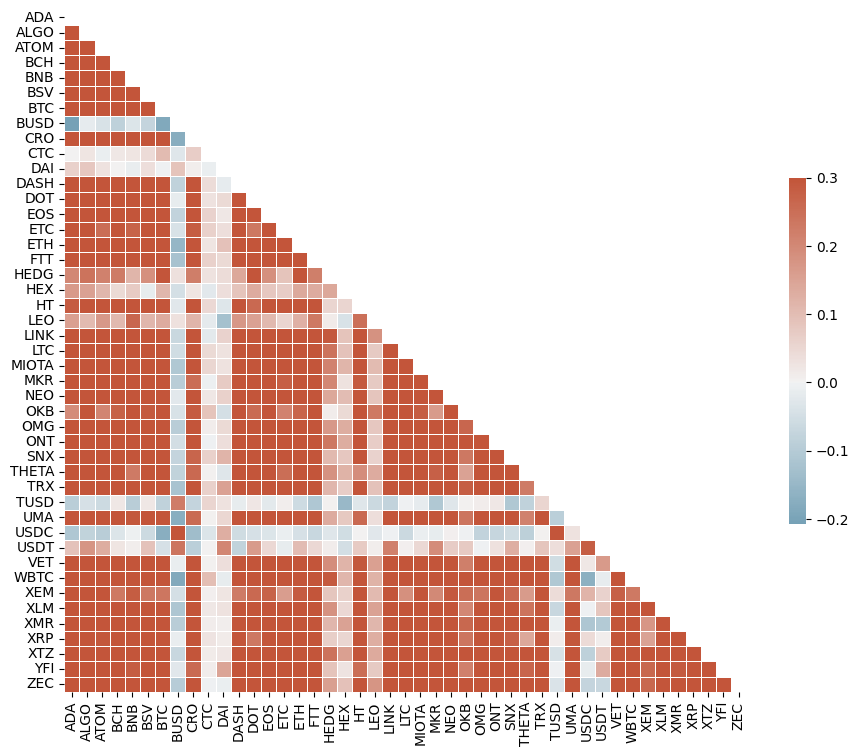

In [31]:
corr_matrix = df_long[df_long["variable"]=="daily_log_return"].drop(["variable", "stablecoin"], axis = 1).pivot(columns="coin", values = "value").corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=True, yticklabels=True)
ax.set(xlabel="", ylabel="")

In [32]:
corr_df = df_long[(df_long["variable"]=="daily_log_return")].drop(["stablecoin", "variable"], axis = 1).pivot(columns = "coin", values="value").corr()
corr_df = corr_df.unstack(level = 0).to_frame().rename(columns = {0:"corr"})
#corr_df = corr_df[corr_df["corr"]!=1].reset_index(level=0).rename(columns={"coin":"cointo"}).reset_index().rename(columns = {"coin":"coinfrom"})
corr_df = corr_df.reset_index(level=0).rename(columns={"coin":"cointo"}).reset_index().rename(columns = {"coin":"coinfrom"})

<Axes: xlabel='corr', ylabel='Count'>

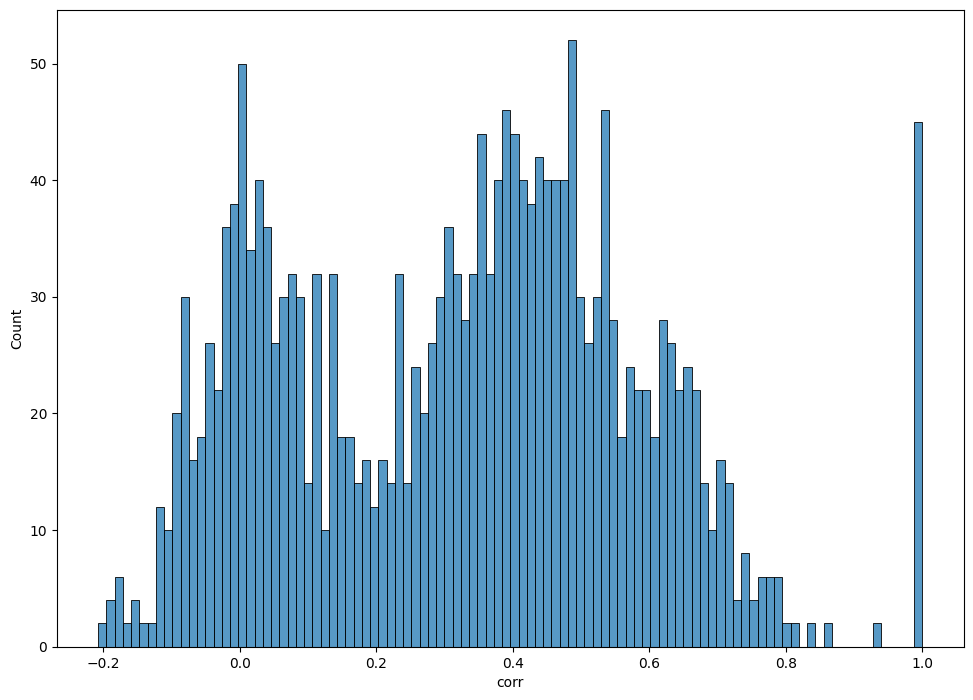

In [33]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=(a4_dims))
sns.histplot(corr_df, x = "corr", bins = 100)

array([[<Axes: title={'center': 'Coeficientes de correlación de retorno entre criptoactivos'}>]],
      dtype=object)

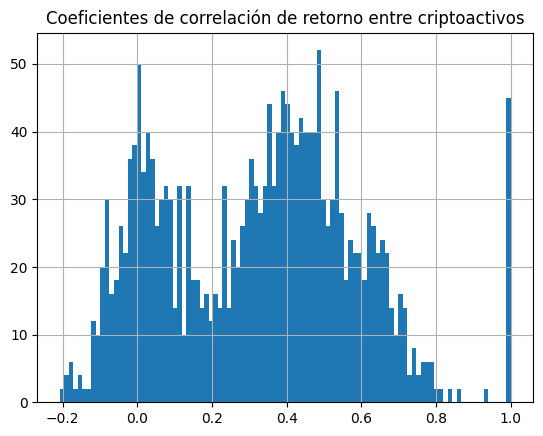

In [34]:
corr_df.rename(columns = {"corr":"Coeficientes de correlación de retorno entre criptoactivos"}).hist(bins = 100)

In [35]:
# Create a range for all correlations
corr_range = []
corr_range.append(corr_df["corr"].min())
while corr_range[-1]<corr_df["corr"].max():
    corr_range.append(corr_range[-1]+0.01)
corr_range.append(corr_df["corr"].max())

#### Graph charts

#### MST

### Create network

In [36]:
G = create_graph(corr_df, stablecoins)
### Save graph
nx.write_graphml_lxml(G, "G.graphml")

#### MST

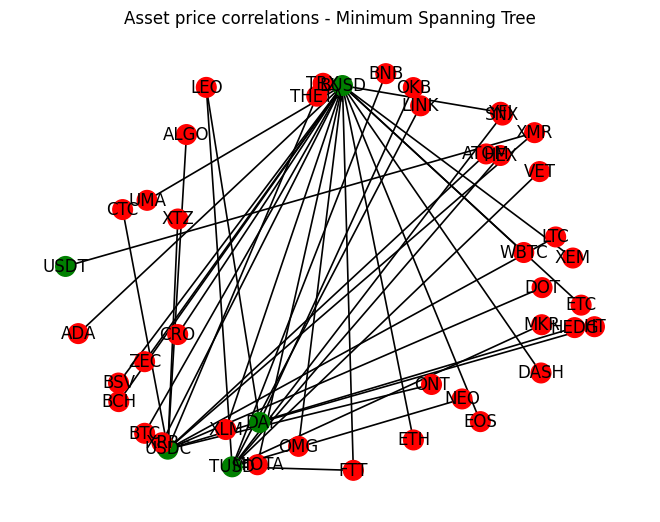

In [37]:
mst = nx.minimum_spanning_tree(G)
color = nx.get_node_attributes(G, "type")
color_map = ["red" if v == "volatile" else "green" for v in color.values()]
nx.draw(mst, with_labels=True, 
        pos=nx.spring_layout(mst),
        node_size=200, 
        node_color  = color_map, 
        width = 1.2)

plt.title("Asset price correlations - Minimum Spanning Tree")
plt.show()

### Find correlation treshold

c:\Users\feder\anaconda3\envs\graph\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

c:\Users\feder\anaconda3\envs\graph\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



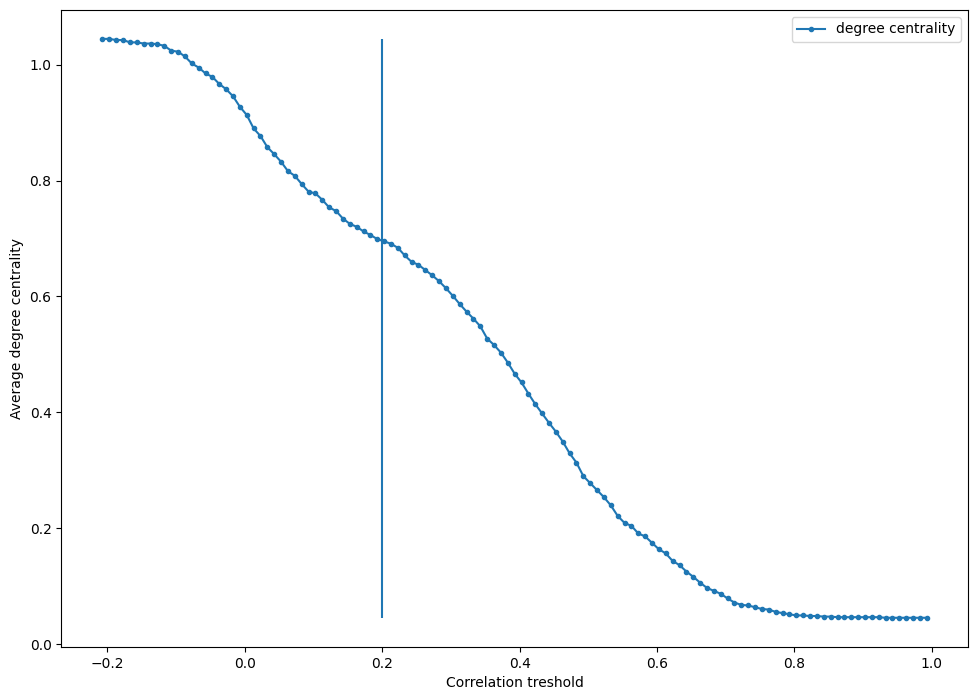

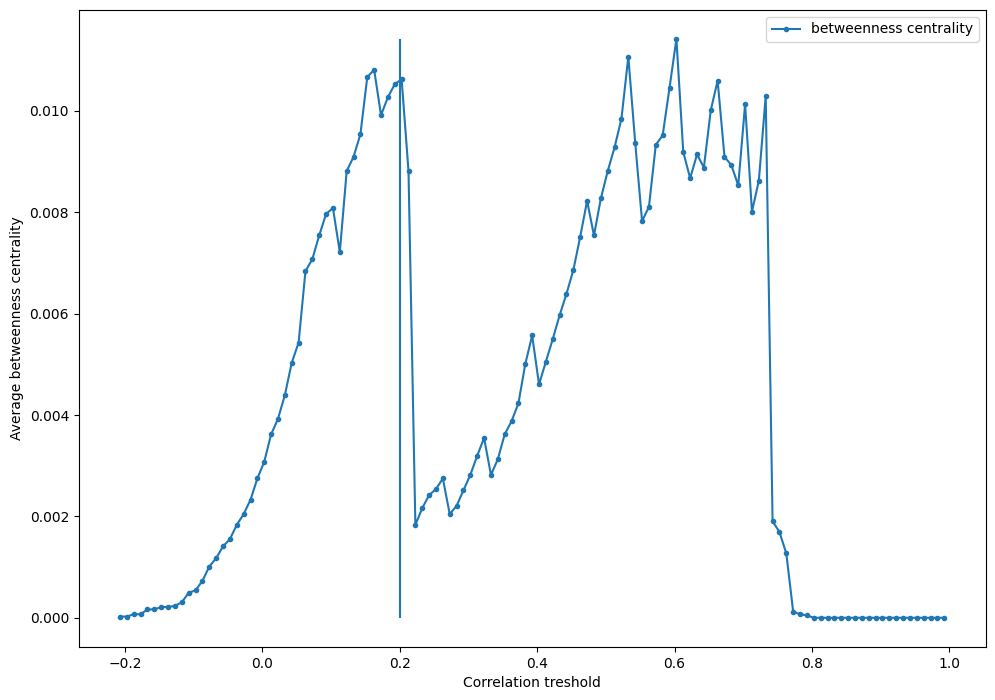

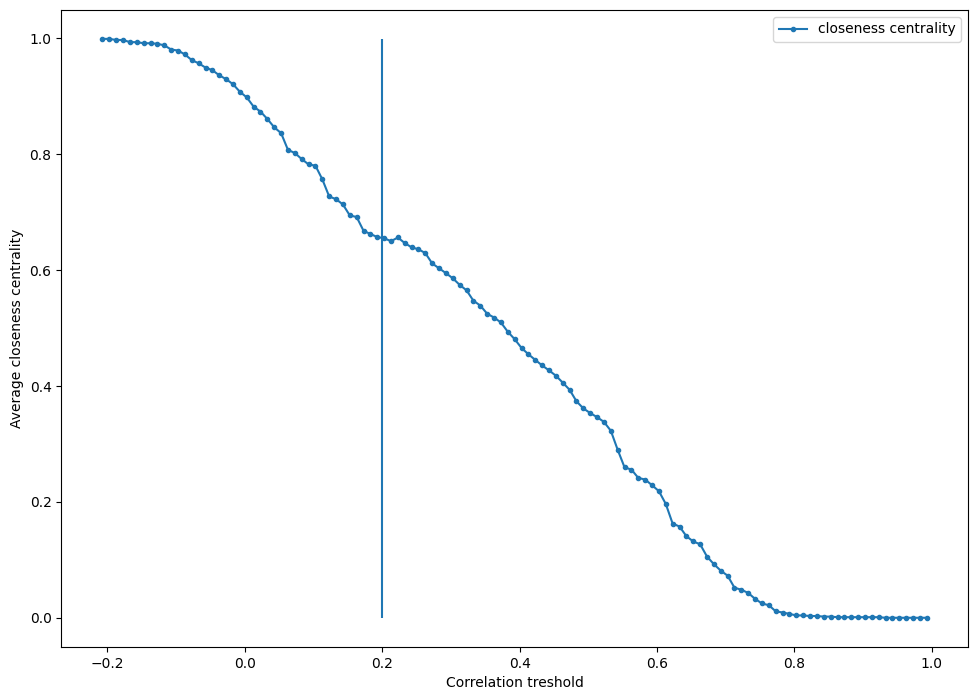

In [38]:
centrality_functions = {
    'degree centrality': nx.degree_centrality,
    'betweenness centrality': nx.betweenness_centrality,
    'closeness centrality': nx.closeness_centrality
    }

for f_name, f in centrality_functions.items():
    mean_values = []
    for c in corr_range:
        G = create_graph(corr_df[corr_df["corr"] > c], stablecoins)
        mean_values.append(np.mean(list(f(G).values())))
    plt.figure(figsize=a4_dims)
    plt.plot(corr_range, mean_values, '.-', label = f_name)
    plt.vlines(0.2, ymin = min(mean_values), ymax = max(mean_values))     
    plt.xlabel('Correlation treshold')
    plt.ylabel('Average %s' % f_name)
    plt.legend()
    plt.show()

#### MST with treshold

In [39]:
G = create_graph(
    corr_df[corr_df["corr"] >= 0.2], 
    stablecoins
    )

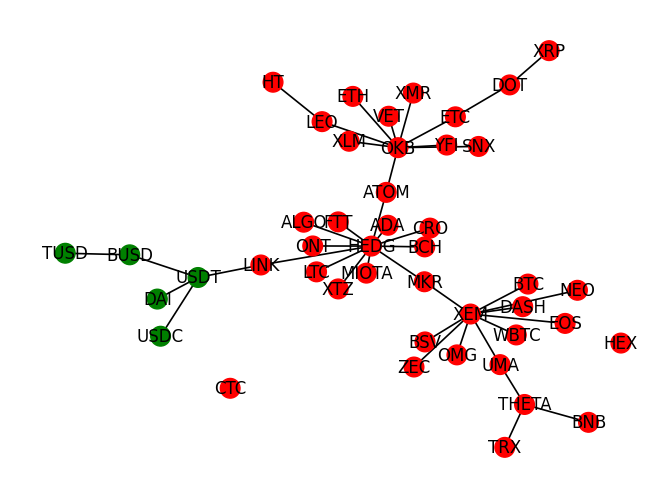

In [40]:

save_images = True
mst = nx.minimum_spanning_tree(G)
color = nx.get_node_attributes(G, "type")
color_map = ["red" if v == "volatile" else "green" for v in color.values()]


nx.draw(mst, 
        with_labels=True, 
        pos=nx.kamada_kawai_layout(mst),
        node_size=200, 
        node_color = color_map, 
        width = 1.2)

if save_images:
    plt.savefig("images/mst.png", format="PNG")
plt.show()


In [41]:
### Save graph
nx.write_graphml_lxml(mst, "mst.graphml")

#### MST Analysis

In [42]:
sub_1 = ["XRP","DOT","YFI","ETC", "VET","OKB","XLM", "LEO", "ETH", "XMR", "HT", "SNX"]
sub_2 = ["XEM", "DASH","WBTC","BSV","NEO","ZEC","EOS","UMA","BTC","OMG","THETA","BNB","TRX"]
sub_3 = ["XTZ", "ADA", "ONT","FTT", "MIOTA","BCH","ATOM","LINK","HEDG","MKR", "ALGO","LTC","XTZ","CRO"]
sub_4 = ["TUSD","BUSD","USDT","DAI","USDC"] #Stablecoins
sub_5 = ["CTC","HEX"]

In [43]:
mst_analysis = df[["coin", "daily_log_return"]].copy()
mst_analysis['mean_return'] = mst_analysis['daily_log_return'].groupby(df['coin']).transform('mean')
mst_analysis['volatility'] = mst_analysis['daily_log_return'].groupby(df['coin']).transform('std')
mst_analysis["subgraph"] = np.where(mst_analysis["coin"].isin(sub_1), 
                          "Subgraph 1",
                          np.where(mst_analysis["coin"].isin(sub_2), 
                            "Subgraph 2",
                            np.where(
                                mst_analysis["coin"].isin(sub_3),
                                "Subgraph 3",
                                np.where(
                                    mst_analysis["coin"].isin(sub_4),
                                    "Stablecoins Subgraph",
                                    np.where(mst_analysis["coin"].isin(sub_5), 
                                             "Subgraph 5", None
                                             )
                                             ))))
mst_analysis = mst_analysis.groupby(["coin","subgraph"]).agg({"mean_return":"mean", "volatility":"mean"}).reset_index().rename(columns = {"volatility":"Volatility", "mean_return":"Mean Return", "subgraph":"Subgraph"})

Text(0.5, 1.0, 'Risk Return Matrix for subgraphs')

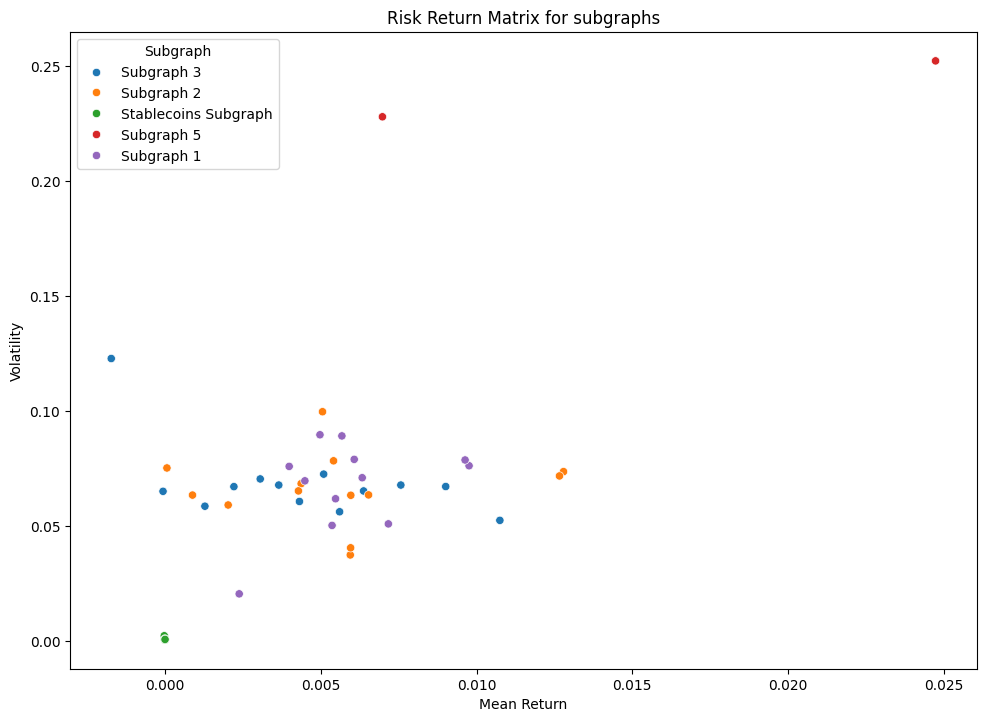

In [44]:
fig, ax = plt.subplots(figsize=(a4_dims))
sns.scatterplot(data=mst_analysis, x = "Mean Return", y = "Volatility", hue = "Subgraph",palette="tab10")
ax.set_title("Risk Return Matrix for subgraphs")

#### Community detection

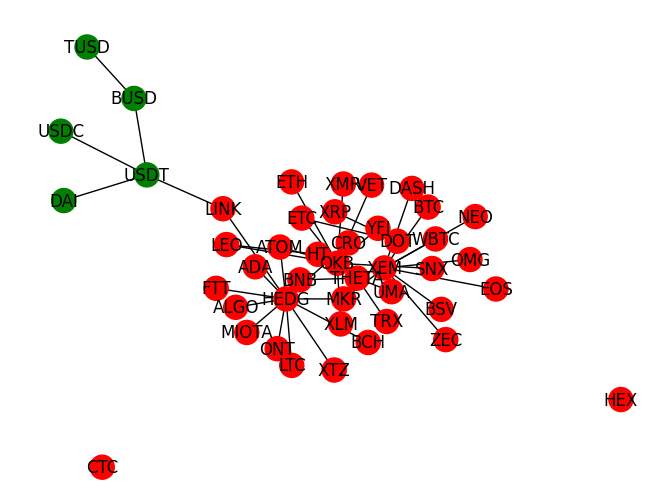

In [45]:
communities = community.louvain_communities(mst)
# find the nodes forming the communities
node_groups = []

for com in communities:
  node_groups.append(list(com))

pos= nx.kamada_kawai_layout(G)
color = nx.get_node_attributes(G, "type")
color_map = ["red" if v == "volatile" else "green" for v in color.values()]

nx.draw(mst, with_labels=True, node_color = color_map, pos = pos)
if save_images:
  plt.savefig("images/community_louvain.png", format="PNG")
plt.show()

Girvan Newman

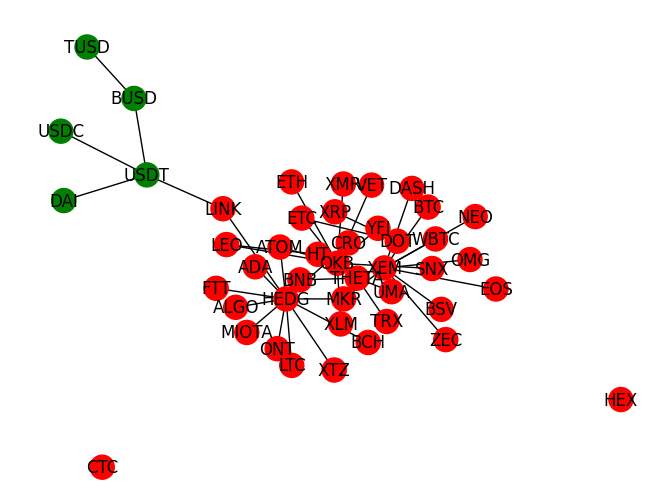

In [48]:
communities = community.girvan_newman(mst)
# find the nodes forming the communities
node_groups = []

for com in communities:
  node_groups.append(list(com))
color = nx.get_node_attributes(G, "type")
color_map = ["red" if v == "volatile" else "green" for v in color.values()]

pos= nx.kamada_kawai_layout(G)
nx.draw(mst,  
        with_labels=True, 
        node_color = color_map, 
        pos = pos)
if save_images:
  plt.savefig("images/community_gn.png", format="PNG")
plt.show()

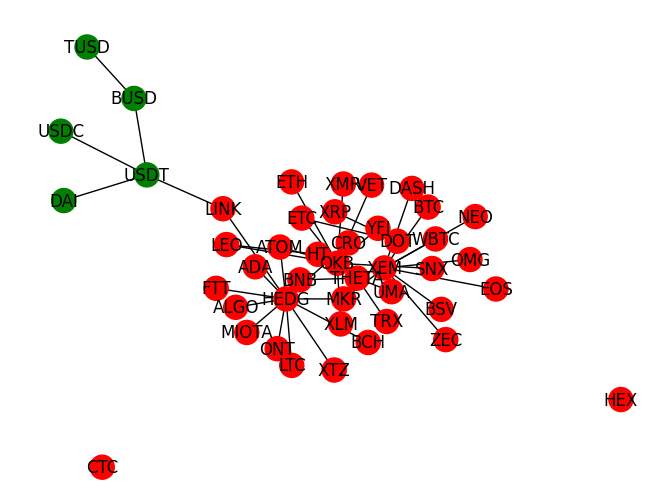

In [47]:
communities = community.k_clique_communities(mst, 2)
# find the nodes forming the communities
node_groups = []

for com in communities:
  node_groups.append(list(com))
color = nx.get_node_attributes(G, "type")
color_map = ["red" if v == "volatile" else "green" for v in color.values()]


nx.draw(mst, 
        with_labels=True, 
        node_color = color_map, 
        pos = nx.kamada_kawai_layout(G))
if save_images:
  plt.savefig("images/community_kclique.png", format="PNG")
plt.show()